In [6]:
%load_ext autoreload
%autoreload 2

In [8]:
import littleglyphs as lilg
import littleglyphs.plotting as lilgplt
import littleglyphs.classification as lilgcls
import littleglyphs.examples as lilgex

In [9]:
import copy
import time

import numpy as np
import scipy
import skimage
import sklearn 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

random_seed = 456

np.random.seed(random_seed)

In [10]:
glyph_alphabet = lilg.examples.MNISTlike_glyph_alphabet()

Ground truth glyphs:


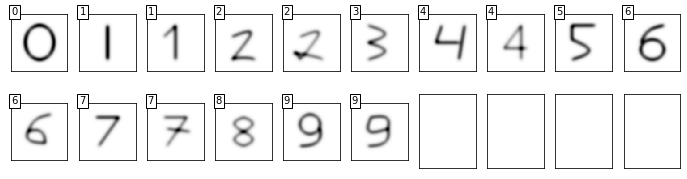

In [11]:
print('Ground truth glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = glyph_alphabet.N_glyphs, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,3)
)
plt.show()

In [6]:
N_glyphs_in_alphabet = 15

N_bezier_features = 0
N_line_features = 0
N_ellipse_features = 0
N_multipoint_line_features = 0
multipoint_line_feature_N_points = 3
N_multipoint_bezier_features = 1
multipoint_bezier_feature_N_points = 3

N_glyph_permutations = 20
permutation_strength = 0.1

imgsize = 16

N_glyph_raster_distortions = 30
rotat_distort_max = np.pi / 8
shear_distort_max = np.pi / 8
scale_distort_max = 0.25

blur_factor = 1

N_variations_per_glyph = N_glyph_permutations*N_glyph_raster_distortions

glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [
        lilg.DistortionRandomAffine(
            rotat_distort_max = rotat_distort_max, 
            shear_distort_max = shear_distort_max,
            scale_distort_max = scale_distort_max
        )
    ]
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)


Examples of glyph images:


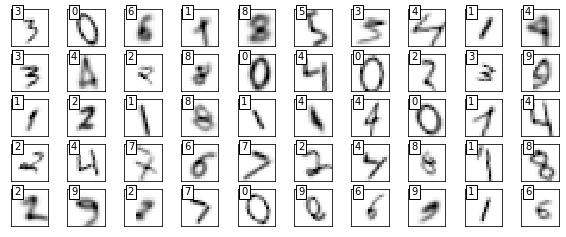

In [7]:
print('Examples of glyph images:')
N_images_to_show = 50

random_indices = np.arange(len(glyph_rasters))
np.random.shuffle(random_indices)
vis_imgs = glyph_rasters[random_indices[0:N_images_to_show]]
vis_categories = glyph_rasters.categories[random_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(10,4))
plt.show()

In [8]:
category_classes, inverse_category_class_indices = np.unique(glyph_rasters.categories, return_inverse=True)
N_classes = len(category_classes)

X = glyph_rasters.rasters
Y = keras.utils.to_categorical(glyph_rasters.categories, num_classes=N_classes)

In [9]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = lilgcls.split_data_for_learning(
    X, Y, 
    crossval_proportion = 0.2, 
    test_proportion = 0.2, 
    random_seed=random_seed
)
    
print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (5760, 16, 16); Y_train matrix shape: (5760, 10)
X_test  matrix shape: (1920, 16, 16); Y_test  matrix shape: (1920, 10)
X_cv    matrix shape: (1920, 16, 16); Y_cv    matrix shape: (1920, 10)


In [10]:
naive_classifier = lilgcls.DistanceMetricClassifier(N_classes, imgsize, lilgcls.image_distance_euclidean)
naive_classifier.train(X_train,Y_train)

In [11]:
acc_test_set = naive_classifier.evaluate(X_test,Y_test)
print('Accuracy on test set: ~'+'{0:.0f}'.format(acc_test_set*100)+'%')

Accuracy on test set: ~65%


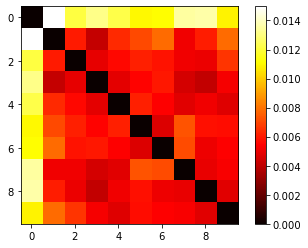

In [12]:
plt.imshow(naive_classifier.cat_distance_matrix, cmap='hot')
plt.colorbar()
plt.show()

In [13]:
Y_predicted = naive_classifier.predict(X_test)
Y_predicted_class = np.argmax(Y_predicted, axis=1)
Y_predicted_probability = np.max(Y_predicted, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)

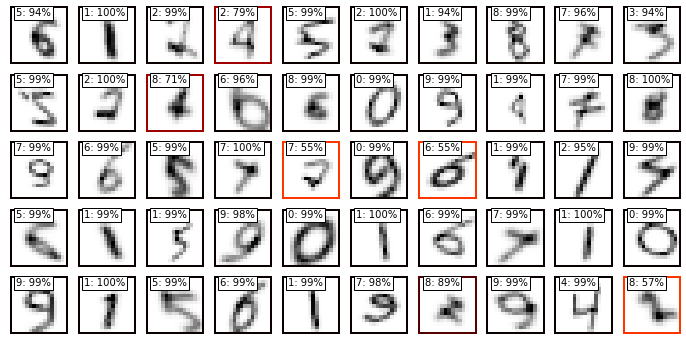

In [14]:
N_images_to_show = 50

vis_imgs = X_test[:N_images_to_show]
vis_categories = Y_predicted_class[:N_images_to_show]
vis_probabilities = Y_predicted_probability[:N_images_to_show]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap = 'hot_r', figsize=(12,6))
plt.show()

Probabilistic confusion entropy matrix:


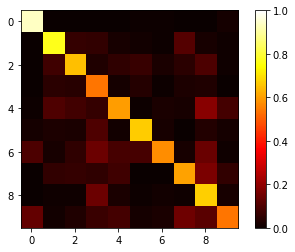

Class with worst performance: 3
Class with best performance:  0


In [15]:
prob_conf_ent_matrix = lilgcls.prob_conf_ent_matrix(Y_test,Y_predicted,N_classes)

worst_class_index = np.diagonal(prob_conf_ent_matrix).argmin()
best_class_index =  np.diagonal(prob_conf_ent_matrix).argmax()

print('Probabilistic confusion entropy matrix:')
#print(np.around(prob_conf_ent_matrix,decimals=3))
plt.imshow(prob_conf_ent_matrix, vmin=0, vmax=1, cmap='hot')
plt.colorbar()
plt.show()
print('Class with worst performance: '+str(worst_class_index))
print('Class with best performance:  '+str(best_class_index))


In [16]:
prob_conf_ent_matrix_nodiag = prob_conf_ent_matrix.copy()
np.fill_diagonal(prob_conf_ent_matrix_nodiag,0)

worst_confusion_index = np.unravel_index(
    np.argmax(prob_conf_ent_matrix_nodiag, axis=None), 
    prob_conf_ent_matrix_nodiag.shape
)
print('Most confused pair: class '
      +str(worst_confusion_index[0])
      +' is being mistaken for class '
      +str(worst_confusion_index[1])
      +' with probability '
      +str(np.around(prob_conf_ent_matrix_nodiag[worst_confusion_index],decimals=3))
     )

Most confused pair: class 4 is being mistaken for class 8 with probability 0.189


Actual distribution of classes for test data:
[114 254 225  97 266 130 244 230 112 248]
Distribution of classes for test data as predicted by the classifier:
[137 290 232 117 264 116 170 231 170 193]
Examples of class 4:


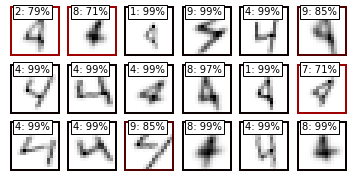

Examples of class 8:


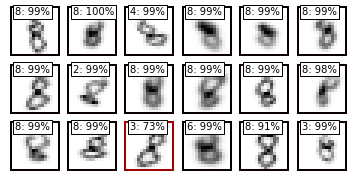

In [17]:
print('Actual distribution of classes for test data:')
print(np.bincount(Y_test_class))
print('Distribution of classes for test data as predicted by the classifier:')
print(np.bincount(Y_predicted_class))

N_images_to_show = 18

print('Examples of class '+str(worst_confusion_index[0])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[0])[0]
vis_indices = vis_indices[:N_images_to_show]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)                            
                            )
plt.show()

print('Examples of class '+str(worst_confusion_index[1])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[1])[0]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,                             
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)
                            )
plt.show()
